In [1]:
#limpio la memoria
rm(list=ls())
gc()

#cargo librerias
library("data.table")
library("ROCR")
library("rpart")
library("rpart.plot")
library("caret")

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,615566,32.9,1335898,71.4,1056224,56.5
Vcells,1154240,8.9,8388608,64.0,1801047,13.8


Loading required package: ggplot2

Loading required package: lattice



In [2]:
setwd("/home/devsar/Documents/Austral/Laboratorio de Implementación")

#Parametros entrada

#kcarpeta_datasets    <- "../input/laboratorio-de-implementacion-i-2021/"   #KAGGLE
kcarpeta_datasets    <- "./datasets/"                          #VM o Ubuntu

#Archivo con datos etiquetados para entrenamiento
karchivo_entrada      <-  paste0(kcarpeta_datasets, "competencia1_2022_FE.csv")

#Formato para submit en Kaggle
#karchivo_score      <-  "../input/uamds2020ldi1f1/Sample_201910_Fase_I.txt"

#Separador de campos en archivos
kcampos_separador     <-  "\t"

#Campo que identifica las muestras
kcampo_id             <-  "numero_de_cliente"

#Campo que contiene la clase a estimar
kclase_nomcampo       <-  "clase_ternaria"

#Valor de interés
kclase_valor_positivo <-  "BAJA+2"

#Campos a borrar para el entrenamiento
kcampos_a_borrar      <-  c(kcampo_id,kclase_nomcampo,"foto_mes")

#Campo que contendrá a la variable objetivo generada
kobjetivo             <-  "clase"

#Identificación del modelo
kmodelo               <-  "02-RPART"

#Ganancia por TP
kTPGain               <-  78000

#Pérdida por FP
kFPGain               <-  -2000

#Establezco semilla aleatoria
set.seed(1)



In [3]:
#cargo los datos
dataset <- fread(karchivo_entrada)

#Para hacer pruebas rapidas puedo reducir el dataset a una fraccion
#subsample <- sample(1:nrow(dataset), .1 * nrow(dataset))
#dataset <- dataset[subsample,]

dtrain  <- dataset[ foto_mes==202101 ]  #defino donde voy a entrenar

train_rows <- createDataPartition(dtrain$clase_ternaria, p = .66, list = FALSE)

#train_rows <- sample(1:nrow(dataset), .66 * nrow(dataset))
dtest <- dtrain[-train_rows,]
dtrain <- dtrain[train_rows,]

dapply  <- dataset[ foto_mes==202103 ]  #defino donde voy a aplicar el modelo

In [4]:
#Funcion que calcula la ganancia para una prediccion y valores reales
fmetrica_ganancia_rpart  = function( probs, clases, pclase_valor_positivo )
{
 
  return(  sum(    (probs > 1/40 ) * 
                   ifelse( clases== pclase_valor_positivo, kTPGain, kFPGain )   
              )
         )
}

In [5]:
# Detalles del modelo
# print(grepl( "2) ctrx_quarter", paste(modelo, sep=" ", collapse=NULL), fixed = TRUE))
# print(paste(modelo, sep=" ", collapse=NULL))

imprimir_variables_relevantes <- function(modelo, dataset) {
    rules <- rpart.rules(modelo, style = "tall")
    colnames(rules) <- c(1:30)
    ordered_rules <- rules[, order(1)]

    cols <- colnames(dataset)

    puntaje_a_repartir <- 1000
    for (row in rules) {
        for (column in row) {
            for (col in cols) {
                if (grepl(col, column, fixed = TRUE)) {
                    message(paste(column[1], "|", puntaje_a_repartir))
                    puntaje_a_repartir <- puntaje_a_repartir - 1
                }
            }
        }
    }
}


In [6]:
# Funcion que entrena el arbol y luego determina la ganancia sobre el set de test
modelo_rpart_ganancia = function( ptrain, ptest, pmaxdepth, pminbucket, pminsplit, pcp )
{
  variables = "ctrx_quarter + g_saldo_total + mpayroll + mv_status02 + mpasivos_margen + mcaja_ahorro + mv_status06 + ctarjeta_master_debitos_automaticos + mtarjeta_visa_consumo + mrentabilidad_annual + g_ratio_90_30 + mprestamos_personales + mcuentas_saldo + tcallcenter + mcuenta_corriente + cpayroll_trx + ccallcenter_transacciones + cliente_antiguedad + mv_msaldototal + cprestamos_personales + mcuenta_corriente_adicional + cdescubierto_preacordado + cliente_edad + mtarjeta_master_consumo + ccomisiones_mantenimiento + ccuenta_debitos_automaticos + mv_mpagominimo + mv_Fvencimiento + mtransferencias_recibidas + mactivos_margen + ctarjeta_master + catm_trx_other + mtransferencias_emitidas + mv_status04 + ctarjeta_visa_debitos_automaticos + mrentabilidad + mcaja_ahorro_adicional + mttarjeta_visa_debitos_automaticos + ccajas_depositos + numero_de_cliente + ccomisiones_otras + mv_mpagado + ctarjeta_visa_transacciones + mpayroll2 + mcaja_ahorro_dolares + ctarjeta_debito + mttarjeta_master_debitos_automaticos + mforex_sell + ctarjeta_visa + ccajas_consultas + mcomisiones_otras + mcomisiones + matm + mcomisiones_mantenimiento + tmobile_app + g_ctxs_virtuales + ctarjeta_master_descuentos + ctarjeta_debito_transacciones + g_prop_txs_app + mpagomiscuentas + mcheques_emitidos + internet + g_ctxs_remotas + mv_mconsumospesos + mtarjeta_master_descuentos + ccajas_extracciones + ctransferencias_emitidas + cpagomiscuentas + cmobile_app_trx + cproductos + mcheques_depositados + mautoservicio + mcuenta_debitos_automaticos + ctarjeta_visa_descuentos + mprestamos_hipotecarios + cinversion2 + mextraccion_autoservicio + mv_status03 + matm_other + ccajeros_propios_descuentos + mv_mconsumosdolares + cseguro_vivienda + g_prom_90_mayor_prom_30 + g_esta_complicado + g_es_activo_virtual + g_es_activo_remoto + g_usa_pago_mis_cuentas + mv_FechaAlta"
  my_formula = paste("clase_ternaria ~", variables)
  modelo   <-  rpart(formula,   data = ptrain,  xval=0, maxdepth=pmaxdepth, minbucket=pminbucket, minsplit=pminsplit, cp=pcp)
  imprimir_variables_relevantes(modelo, dataset)
  #aplico el modelo a datos nuevos
  testing_prediccion  <- predict( modelo, ptest)[, "BAJA+2"]
    
  return(fmetrica_ganancia_rpart(testing_prediccion,ptest[,..kclase_nomcampo],"BAJA+2"))
  
}

In [7]:
#Cuenta los modelos probados
linea <- 1

#Establece una ganancia inicial muy baja a superar
max_gan <- -100000000

#For anidados para grid search 
for( vcp in c(-0.35)) #Complexity Factor
for( vmaxdepth in  c(6, 7, 13, 14) ) #max Depth
for( vminsplit in  c(800, 900, 1000, 1200 ) ) #Min Split
for( vminbucket  in  unique( as.integer(c(3,  5, 150, 250, 400 )) ) ) #Min Bucket
{ 

    #Muestra los parametros a testear
    message(paste('Intentando',vcp,vmaxdepth, vminsplit,vminbucket))
    #Llama a la funcion que entrena el modelo y calcula la ganancia para esos parametros
    res <- modelo_rpart_ganancia( dtrain, dtest, 
                                  pmaxdepth=vmaxdepth, pminbucket=vminbucket, pminsplit=vminsplit, pcp=vcp )

    
  
    #Verifica si se supero la mejor ganancia hasta el momento. En caso de haberla superado graba los hiperparametros nuevos
    if (res>max_gan) {
      max_gan <- res
      message(paste("Nuevo Maximo: ", res*3, vcp,vminsplit,vminbucket,vmaxdepth))
      pcp<-vcp
      pminsplit<-vminsplit
      pminbucket<-vminbucket
      pmaxdepth<-vmaxdepth
  }
  #Muestra al ganancia de la iteracion
  message(paste('Ganancia:',res*3,'Ganancia Maxima',max_gan*3))
    
  linea <- linea+1


}

Intentando -0.35 6 800 3

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.rules with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”
ctrx_quarter | 1000

ctrx_quarter | 999

ctrx_quarter | 998

ctrx_quarter | 997

ctrx_quarter | 996

ctrx_quarter | 995

ctrx_quarter | 994

ctrx_quarter | 993

ctrx_quarter | 992

ctrx_quarter | 991

ctrx_quarter | 990

ctrx_quarter | 989

ctrx_quarter | 988

ctrx_quarter | 987

ctrx_quarter | 986

ctrx_quarter | 985

ctrx_quarter | 984

ctrx_quarter | 983

ctrx_quarter | 982

ctrx_quarter | 981

ctrx_quarter | 980

ctrx_quarter | 979

ctrx_quarter | 978

ctrx_quarter | 977

ctrx_quarter | 976

ctrx_quarter | 975

ctrx_quarter | 974

ctrx_quarter | 973

ctrx_quarter | 972

ctrx_quarter | 971

ctrx_quarter | 970

mv_status02 | 969

mv_status02 | 968

mv_status02 | 967

mv_status02 | 966

mv_status02 | 965

mv_status02

In [7]:
#Entrena el modelo con el dataset completo
t0       <-  Sys.time()
modelo   <-  rpart("clase_ternaria ~ .",   data = dtrain,   xval=0, maxdepth=pmaxdepth, minbucket=pminbucket, minsplit=pminsplit, cp=pcp)
t1       <-  Sys.time()

tcorrida <-  as.numeric( t1 - t0, units = "secs")
print( tcorrida)

[1] 7.415441


Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


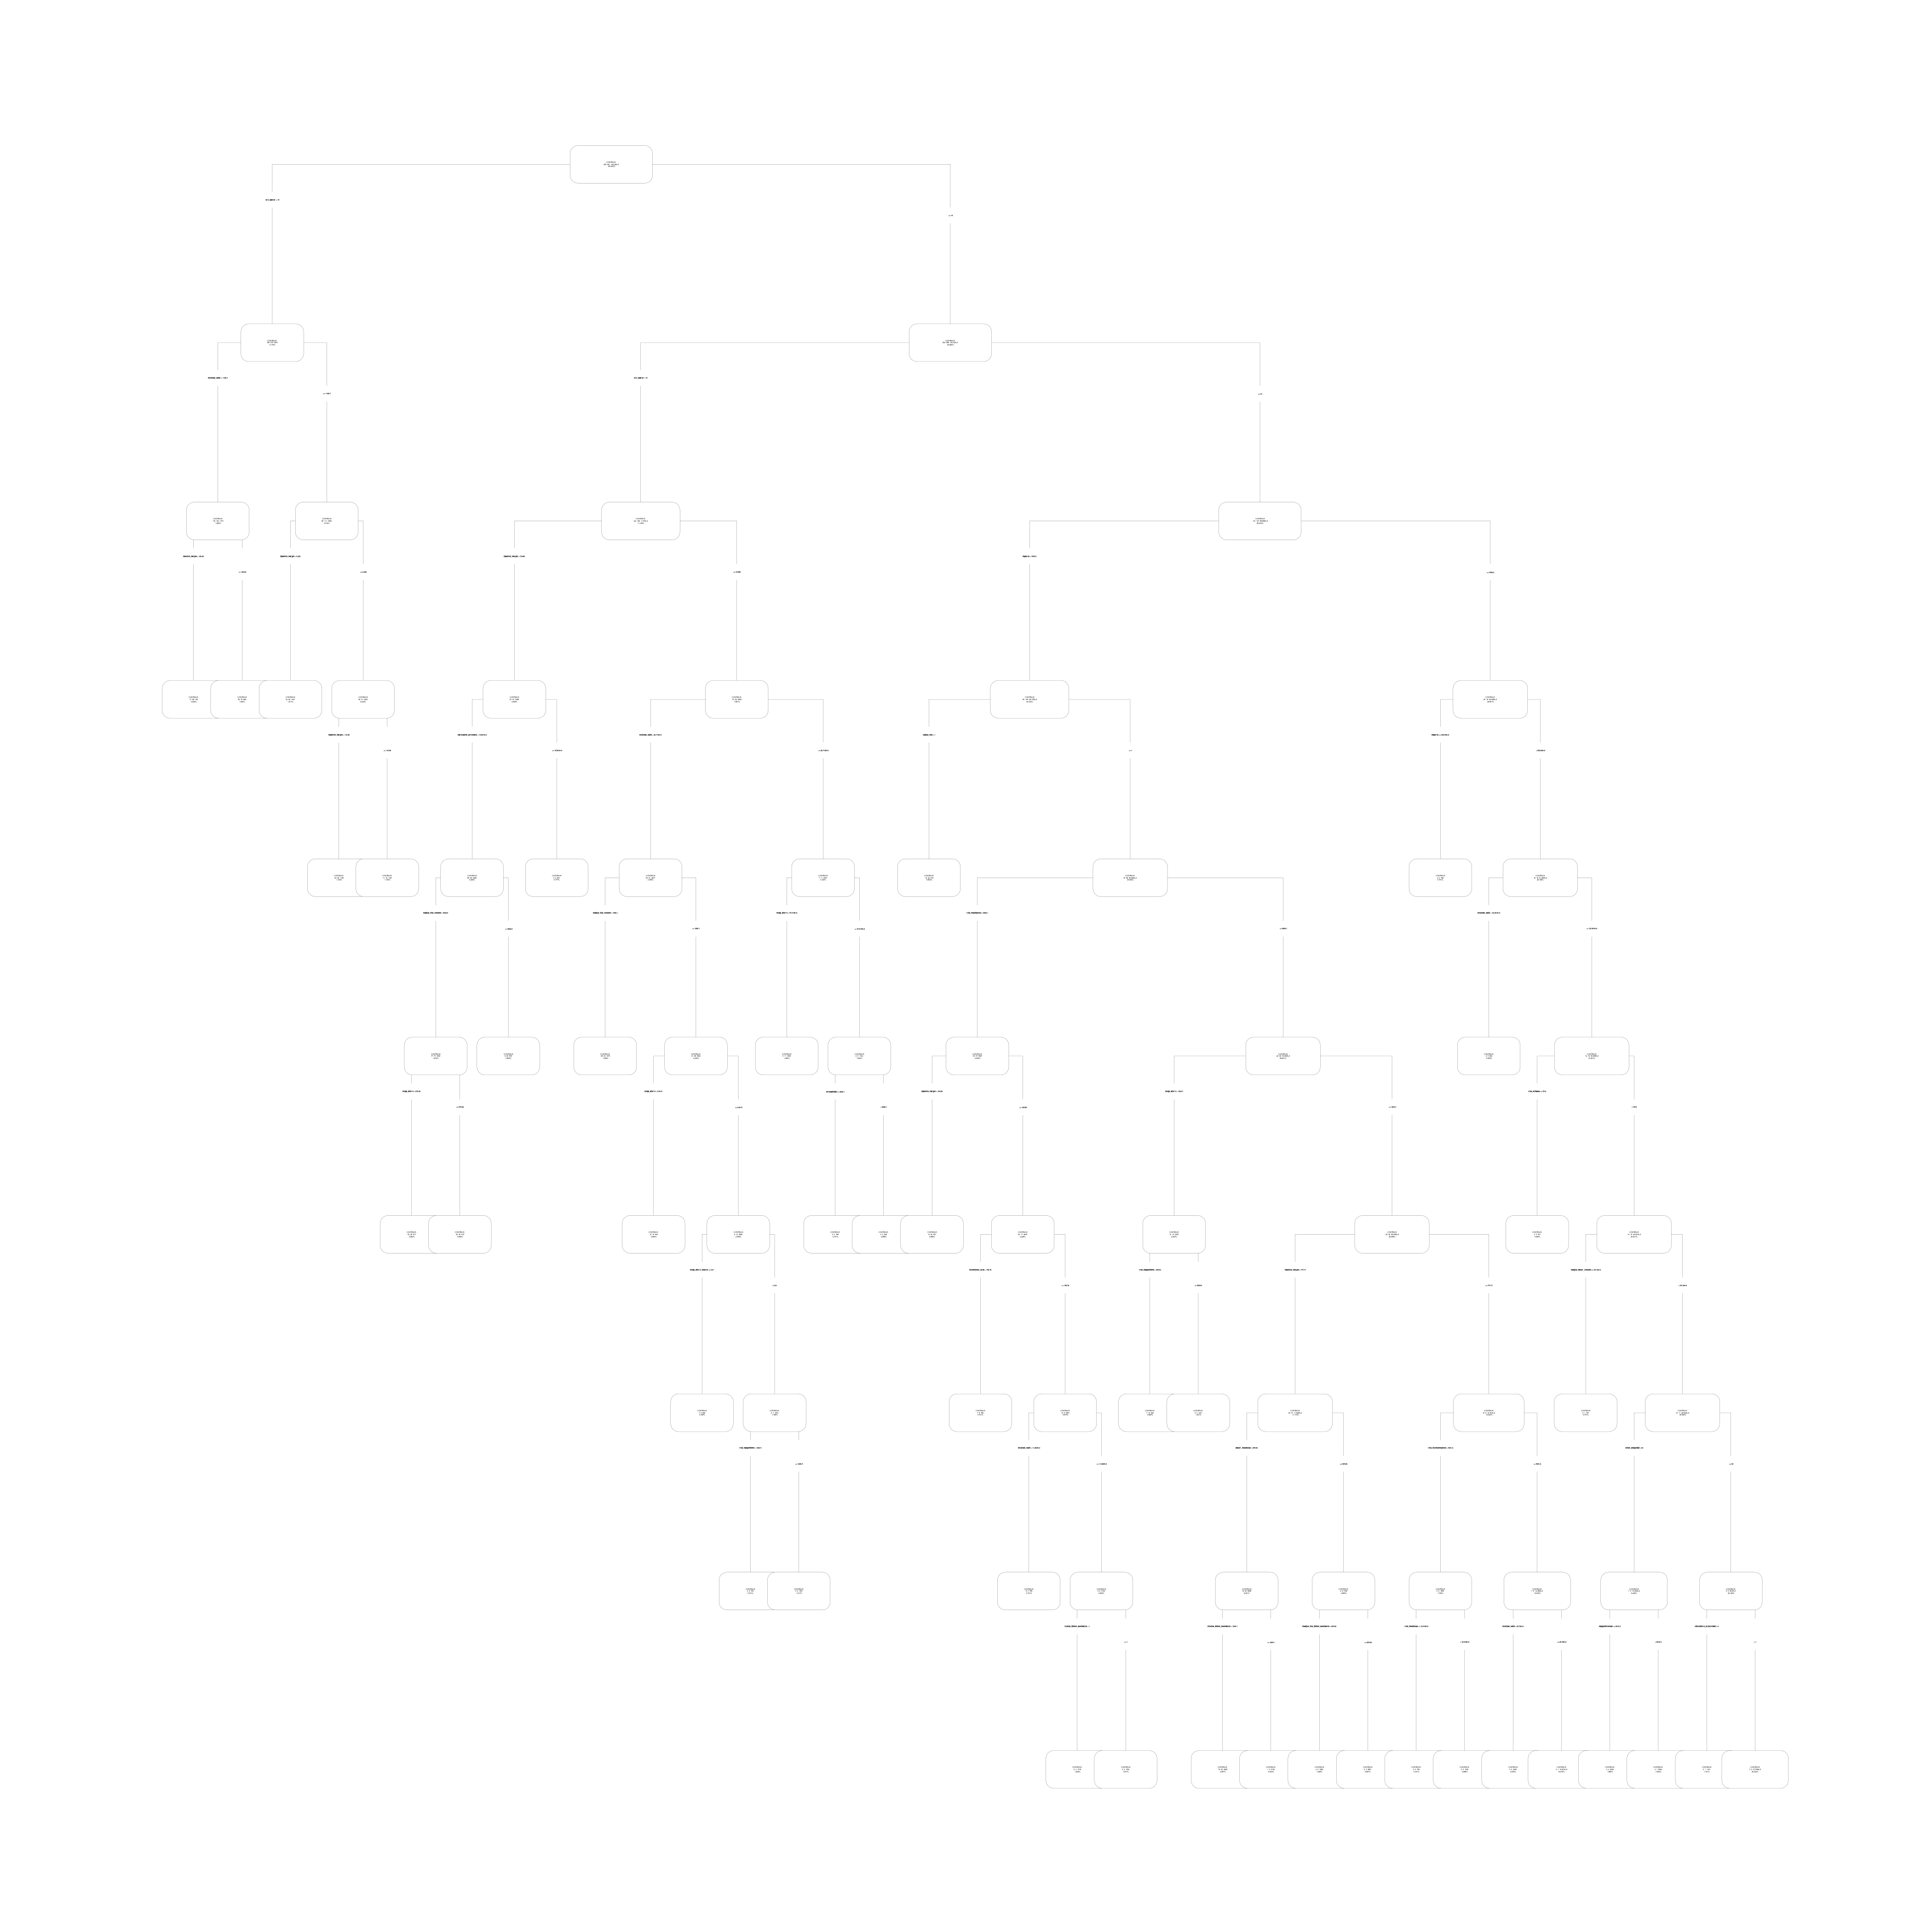

In [10]:
#Arbol generado
options(repr.plot.width=35, repr.plot.height=35, repr.plot.pointsize=88)
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0, tweak=1.3)

In [ ]:
prediccion  <- predict( modelo, dapply , type = "prob") #aplico el modelo
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/40) ]
dir.create( "./exp/RPART" )
fwrite( dapply[ , list(numero_de_cliente, Predicted) ], #solo los campos para Kaggle
        file= "./exp/RPART/RPART-GRID.csv", 
        sep= "," )